In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
from sklearn.feature_selection import mutual_info_classif

from torch import Tensor, jit

from tqdm import tqdm

In [2]:
@jit.script
def logsumexp(x: Tensor, dim: int) -> Tensor:
    """Stable logsumexp."""
    # cite: https://github.com/pytorch/pytorch/issues/31829
    m, _ = x.max(dim=dim)
    mask = m == -float("inf")

    s = (x - m.masked_fill_(mask, 0).unsqueeze(dim=dim)).exp().sum(dim=dim)
    return s.masked_fill_(mask, 1).log() + m.masked_fill_(mask, -float("inf"))


In [3]:
class PSSNN(torch.nn.Module):
    def __init__(self, tau):
        super().__init__()
        self.tau = tau

    def forward(self, x, label):
        pair_mat = (label[None, :] != label[:, None]).float()
        sim = F.cosine_similarity(x[None, :, :], x[:, None, :], dim=-1)
        n = sim.size(0)
        sim = sim.clone()
        sim[torch.eye(n).bool()] = float("-Inf")

        pos_mask = pair_mat == 0
        neg = pair_mat * sim
        neg[pos_mask] = float("-Inf")
        losses = -logsumexp(neg / self.tau, dim=1) + logsumexp(sim / self.tau, dim=1)
        finite_mask = torch.isfinite(losses)
        return losses[finite_mask].mean()
    
class SNN(torch.nn.Module):
    def __init__(self, tau):
        super().__init__()
        self.tau = tau

    def forward(self, x, label):
        pair_mat = (label[None, :] == label[:, None]).float()
        sim = F.cosine_similarity(x[None, :, :], x[:, None, :], dim=-1)
        n = sim.size(0)
        sim = sim.clone()
        sim[torch.eye(n).bool()] = float("-Inf")

        neg_mask = pair_mat == 0
        pos = pair_mat * sim
        pos[neg_mask] = float("-Inf")
        losses = -logsumexp(pos / self.tau, dim=1) + logsumexp(sim / self.tau, dim=1)
        finite_mask = torch.isfinite(losses)
        return losses[finite_mask].mean()

In [4]:
def generate_gaussian_blobs(
    n_blobs: int = 3,
    n_samples: int = 100,
    dim: int = 3,
    centers: list = [-1.,2.,7.],
    cluster_std: float = 1.0
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Generates isotropic Gaussian blobs with PyTorch.
    
    Args:
        n_blobs: Number of clusters
        n_samples: Total samples (evenly distributed across clusters)
        dim: Data dimensionality
        center_range: Bounds for cluster centers
        cluster_std: Standard deviation for all clusters
    
    Returns:
        samples: Tensor of shape (n_samples, dim)
        labels: Cluster indices tensor of shape (n_samples,)
    """
    # Generate random cluster centers
    centers = torch.tensor(centers).unsqueeze(1).repeat(1, dim)
    # Create distributions for each cluster
    distributions = [
        MultivariateNormal(
            loc=centers[i],
            covariance_matrix=torch.eye(dim) * cluster_std**2
        ) for i in range(n_blobs)
    ]
    
    # Sample points and create labels
    samples_per_blob = n_samples // n_blobs
    samples = torch.cat([d.sample((samples_per_blob,)) for d in distributions])
    labels = torch.cat([torch.full((samples_per_blob,), i) for i in range(n_blobs)])
    
    return samples, labels


In [7]:
np.linspace(1,4,11)

array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ])

In [46]:
N = 1500

I_hat = []

pssnn_tinyt = PSSNN(tau=0.1).cuda()
pssnn_lowt = PSSNN(tau=0.3).cuda()
pssnn_midt = PSSNN(tau=0.5).cuda()
pssnn_hight = PSSNN(tau=1.0).cuda()

PS_ub_tinyt = []
PS_ub_lowt = []
PS_ub_midt = []
PS_ub_hight = []

for sd in tqdm(np.linspace(1,4,11)):
    for _ in range(100):
        x, y = generate_gaussian_blobs(n_samples=N, centers = [-1.,2.,7.], cluster_std=sd)
        indices = torch.randperm(x.size(0))
        x, y = x[indices].cuda(), y[indices].cuda()

        _I_had = mutual_info_classif(x.cpu().numpy(), y.cpu().numpy()).mean()

        I_hat.append(_I_had)

        _PS_ub_tinyt = pssnn_tinyt(x, y)
        PS_ub_tinyt.append(float(_PS_ub_tinyt))

        _PS_ub_lowt = pssnn_lowt(x, y)
        PS_ub_lowt.append(float(_PS_ub_lowt))

        _PS_ub_midt = pssnn_midt(x, y)
        PS_ub_midt.append(float(_PS_ub_midt))

        _PS_ub_hight = pssnn_hight(x, y)
        PS_ub_hight.append(float(_PS_ub_hight))


100%|██████████| 11/11 [00:27<00:00,  2.49s/it]


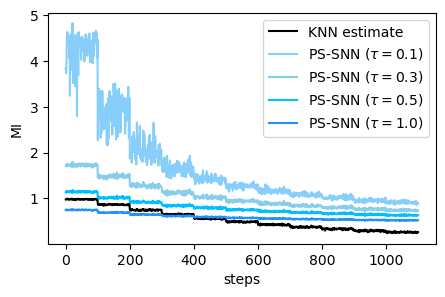

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 3))
plt.plot(I_hat, label='KNN estimate', color='black')

plt.plot(PS_ub_tinyt, label='PS-SNN $(\\tau = 0.1)$', color='lightskyblue')
plt.plot(PS_ub_lowt, label='PS-SNN $(\\tau = 0.3)$', color='skyblue')
plt.plot(PS_ub_midt, label='PS-SNN $(\\tau = 0.5)$', color='deepskyblue')
plt.plot(PS_ub_hight, label='PS-SNN $(\\tau = 1.0)$', color='dodgerblue')
# plt.xticks([0, 250, 500, 750, 1000])
plt.xlabel("steps")
plt.ylabel("MI")
plt.legend()
plt.savefig('./mi-min.pdf', format="pdf", bbox_inches='tight', dpi=150)

In [48]:
N = 1500

I_hat = []

snn_tinyt = SNN(tau=0.1).cuda()
snn_lowt = SNN(tau=0.3).cuda()
snn_midt = SNN(tau=0.5).cuda()
snn_hight = SNN(tau=1.0).cuda()

lb_tinyt = []
lb_lowt = []
lb_midt = []
lb_hight = []

for sd in tqdm(np.linspace(4,1,11)):
    for _ in range(100):
        x, y = generate_gaussian_blobs(n_samples=N, centers = [-1.,2.,7.], cluster_std=sd)
        indices = torch.randperm(x.size(0))
        x, y = x[indices].cuda(), y[indices].cuda()

        _I_had = mutual_info_classif(x.cpu().numpy(), y.cpu().numpy()).mean()

        I_hat.append(-_I_had)

        _lb_tinyt = snn_tinyt(x, y)
        lb_tinyt.append(float(_lb_tinyt))

        _lb_lowt = snn_lowt(x, y)
        lb_lowt.append(float(_lb_lowt))

        _lb_midt = snn_midt(x, y)
        lb_midt.append(float(_lb_midt))

        _lb_hight = snn_hight(x, y)
        lb_hight.append(float(_lb_hight))


100%|██████████| 11/11 [00:28<00:00,  2.60s/it]


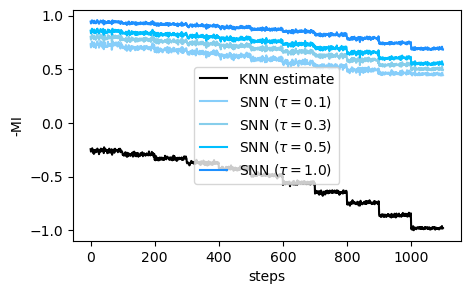

In [49]:
plt.figure(figsize=(5, 3))
plt.plot(I_hat, label='KNN estimate', color='black')
plt.plot(lb_tinyt, label='SNN $(\\tau = 0.1)$', color='lightskyblue')
plt.plot(lb_lowt, label='SNN $(\\tau = 0.3)$', color='skyblue')
plt.plot(lb_midt, label='SNN $(\\tau = 0.5)$', color='deepskyblue')
plt.plot(lb_hight, label='SNN $(\\tau = 1.0)$', color='dodgerblue')
plt.xlabel("steps")
plt.ylabel("-MI")
plt.legend()
plt.savefig('./mi-max.pdf', format="pdf", bbox_inches='tight', dpi=150)